In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from upsetplot import UpSet, from_memberships
from itertools import combinations
from typing import List, Dict
import warnings
import marsilea as ma
from scipy.stats import gaussian_kde

# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
TOOL_DIR = "tools"
OUT_DIR = "../chapters/4_results_and_discussion/figures/detection"
tools = [tool_csv[:-4] for tool_csv in os.listdir(TOOL_DIR)]
tools

['find_circ', 'segemehl', 'dcc', 'circexplorer2', 'ciriquant']

In [3]:
correct_total_counts = True

In [4]:
n_plots = len(tools)
n_cols = 2
n_rows = n_plots // n_cols + 1

In [5]:
def parse_locstring(locstring: str):
    chrom, coords, strand = locstring.split(":")
    start, end = coords.split("-")
    return chrom, int(start), int(end), strand

In [6]:
def get_tool_data(tool: str, min_samples=1):
    df = pd.read_csv(os.path.join(TOOL_DIR, f"{tool}.csv"), sep='\t', index_col=0)
    df.fillna(0, inplace=True)
    
    df_stats = pd.DataFrame(index=df.index)
    df_stats["n_samples"] = (df>0).sum(axis=1)
    df_stats["total_counts"] = df.sum(axis=1)
    if correct_total_counts:
        df_stats["total_counts"] = df_stats["total_counts"] - df_stats["n_samples"]

    mask = df_stats['n_samples'] > min_samples
    df = df[mask]
    df_stats = df_stats[mask]

    df_loc = pd.DataFrame([parse_locstring(loc) for loc in df.index], columns=["chrom", "start", "end", "strand"], index=df.index)
    df_loc["tool"] = tool

    # Merge df_stats and df_loc
    df_stats = pd.concat([df_stats, df_loc], axis=1)

    return df, df_stats

In [7]:
def scatter_tools(tool_stats: pd.DataFrame, outfile: str):
    _, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

    for i, tool in enumerate(tools):
        df_stats = tool_stats[tool]
        ax = axs.flatten()[i]
        sns.scatterplot(x="n_samples", y="total_counts", data=df_stats, ax=ax)
        ax.set_title(tool)

        ax.set_yscale("log")

    plt.tight_layout()
    plt.savefig(outfile)
    plt.close()

In [8]:
def hist_tools(df_locs: pd.DataFrame, grouping: List[str], outfile: str):
    df_grouped = df_locs.groupby(grouping).aggregate({"tool": "nunique"})
    sns.histplot(df_grouped["tool"], discrete=True)
    plt.yscale("log")
    plt.xticks(range(1, len(tools)+1))

    plt.tight_layout()
    plt.savefig(outfile)
    plt.close()

In [9]:
def get_diff_groups(df_locs: pd.DataFrame, max_diff: int = 0):
    df_diff = df_locs.sort_values(["chrom", "end"])
    df_diff["end_group"] = df_diff.groupby("chrom")["end"].diff().gt(max_diff).cumsum()
    df_diff = df_diff.sort_values(["chrom", "start"])
    df_diff["start_group"] = df_diff.groupby("chrom")["start"].diff().gt(max_diff).cumsum()

    return df_diff

In [10]:
def plot_diff_upset(diff_df: Dict[int, pd.DataFrame], outdir: str):
    os.makedirs(outdir, exist_ok=True)
    diff_plotdata = {}
    for diff, df in diff_df.items():
        df_grouped = df.groupby(["chrom", "start_group", "end_group"]).aggregate({"tool": list})
        plotdata = from_memberships(df_grouped["tool"])
        diff_plotdata[diff] = plotdata

        upset = UpSet(plotdata, subset_size="count", min_degree=2, min_subset_size=10)
        upset.plot()
        plt.title(f"Max diff: {diff}", fontsize=16)

        plt.savefig(os.path.join(outdir, f"diff_{diff}.png"))
        plt.close()

    return diff_plotdata

In [11]:
def plot_pies(diff_plotdata: Dict[int, pd.Series], outfile: str):
    font_size = 20

    n_cols = 3
    n_rows = len(tools) // n_cols + 1

    _, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

    def get_count(investigation, diff=0):
        index = [[investigation[tool] for tool in tools]]
        return diff_plotdata[diff].loc[index].sum() if diff_plotdata[diff].index.isin(index).any() else 0

    cmap = plt.colormaps["tab20c"]
    colors = cmap(np.arange(len(tools))*4)

    for i, tool in enumerate(tools):
        others = [t for t in tools if t != tool]
        diff_overlaps = {}
        for diff in [0,1]:
            n_counts = {}
            for n_others in range(len(tools)):
                sum_count = 0
                for other_tools in combinations(others, n_others):
                    investigation = {t: t in other_tools + (tool,) for t in tools}
                    sum_count += get_count(investigation, diff)
                n_counts[n_others] = sum_count
            diff_overlaps[diff] = n_counts
        
        df_overlaps = pd.DataFrame(diff_overlaps).T
        
        size = 0.4

        ax = axs.flatten()[i]
        ax.pie(df_overlaps.loc[1], radius=1.2, wedgeprops=dict(width=size, edgecolor='w'), colors=colors)
        wedges, _ = ax.pie(df_overlaps.loc[0], radius=1.2-size, wedgeprops=dict(width=size, edgecolor='w'), colors=colors)
        ax.set_title(tool, fontsize=font_size)

    ax = axs.flatten()[-1]
    legend = ax.legend(wedges, range(len(tools)), title="Number of agreeing tools", loc='center', fontsize=font_size)

    plt.setp(legend.get_title(), fontsize=font_size)

    for direction in ['top', 'right', 'left', 'bottom']:
        ax.spines[direction].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout()
    plt.savefig(outfile)
    plt.close()


In [12]:
def plot_densities(df: pd.DataFrame, outdir: str):
    os.makedirs(outdir, exist_ok=True)

    df['d0'] = df.groupby(["chrom", "start", "end"])['tool'].transform('nunique')
    df['d1'] = df.groupby(["chrom", "start_group", "end_group"])['tool'].transform('nunique')

    def get_binned(df: pd.DataFrame, bin_col: str, n_bins: int, match_col: str = 'd0', log: bool = False):
        c_bin = df[bin_col].copy()
        if log:
            c_bin = np.log1p(c_bin)
        bins = np.linspace(c_bin.min(), c_bin.max(), n_bins)
        df['bin'] = pd.cut(c_bin, bins, include_lowest=True)
        df_grouped = df.groupby('bin').aggregate(match_col).value_counts(normalize=True).unstack().fillna(0)

        df_grouped.index = df_grouped.index.map(lambda x: x.mid)

        return df_grouped

    for tool in tools:
        if tool == "segemehl":
            continue # TODO: Process segemehl data
        df_tool = df[df['tool'] == tool].copy()

        wb = ma.WhiteBoard(width=3, height=3)
        # Reserve empty canvas for drawing latter
        barplot_size = 0.8
        barplot_pad = 0.1
        wb.add_canvas("top", size=barplot_size, pad=barplot_pad, name="x1")
        wb.add_canvas("left", size=barplot_size, pad=barplot_pad, name="y1")
        wb.add_canvas("top", size=barplot_size, pad=barplot_pad, name="x2")
        wb.add_canvas("left", size=barplot_size, pad=barplot_pad, name="y2")
        # Add title
        wb.add_title(top=f"{tool}: Density plot")
        wb.render()

        values = np.vstack([df_tool["n_samples"], df_tool["total_counts"]])
        kernel = np.log(gaussian_kde(values)(values))
        main_ax = wb.get_main_ax()
        main_ax.yaxis.tick_right()
        main_ax.scatter(df_tool["n_samples"], df_tool["total_counts"], c=kernel, s=10)
        main_ax.set_yscale("log")
        main_ax.set_xlabel("Number of samples")
        main_ax.set_ylabel("Total counts")
        main_ax.yaxis.set_label_position("right")

        cmap = plt.colormaps["tab20c"]
        colors = cmap(np.arange(len(tools))*4)

        kwargs = {
            'stacked': True,
            'legend': False,
            'width': 1,
            'color': colors
        }

        x1_ax = wb.get_ax("x1")
        get_binned(df_tool, "n_samples", 10, 'd0').plot(kind='bar', ax=x1_ax, **kwargs)
        sns.despine(ax=x1_ax, bottom=False, top=True)
        x1_ax.tick_params(bottom=False, labelbottom=False)
        x1_ax.set_xlabel("")
        x1_ax.set_ylabel("Diff: 0", rotation=0)
        x1_ax.yaxis.set_label_coords(-0.15, 0.4)

        y1_ax = wb.get_ax("y1")
        get_binned(df_tool, "total_counts", 10, 'd0', log=True).plot(kind='barh', ax=y1_ax, **kwargs)
        sns.despine(ax=y1_ax, left=True, right=False)
        y1_ax.tick_params(right=False, labelright=False)
        y1_ax.set_ylabel("")
        y1_ax.set_xlabel("Diff: 0")

        for tick in y1_ax.get_xticklabels():
            tick.set_rotation(90)
        y1_ax.invert_xaxis()

        x2_ax = wb.get_ax("x2")
        get_binned(df_tool, "n_samples", 10, 'd1').plot(kind='bar', ax=x2_ax, **kwargs)
        sns.despine(ax=x2_ax, bottom=False, top=True)
        x2_ax.tick_params(bottom=False, labelbottom=False)
        x2_ax.set_xlabel("")
        x2_ax.set_ylabel("Diff: 1", rotation=0)
        x2_ax.yaxis.set_label_coords(-0.15, 0.4)

        y2_ax = wb.get_ax("y2")
        get_binned(df_tool, "total_counts", 10, 'd1', log=True).plot(kind='barh', ax=y2_ax, **kwargs)
        sns.despine(ax=y2_ax, left=True, right=False)
        y2_ax.tick_params(right=False, labelright=False)
        y2_ax.set_ylabel("")
        y2_ax.set_xlabel("Diff: 1")

        for tick in y2_ax.get_xticklabels():
            tick.set_rotation(90)
        y2_ax.invert_xaxis()

        wb.figure.savefig(os.path.join(outdir, f"{tool}.png"), bbox_inches='tight')
        plt.close()

In [13]:
def plot(outdir: str, min_samples = 0):
    tool_counts = {}
    tool_stats = {}

    for tool in tools:
        tool_counts[tool], tool_stats[tool] = get_tool_data(tool, min_samples)

    df_stats = pd.concat(tool_stats.values(), axis=0)

    scatter_tools(tool_stats, os.path.join(outdir, "scatterplot.png"))
    hist_tools(df_stats, ["chrom", "start", "end", "strand"], os.path.join(outdir, "histplot_all.png"))
    hist_tools(df_stats, ["chrom", "start", "end"], os.path.join(outdir, "histplot_nostrand.png"))
    
    diffs = [0, 1, 2, 3, 4, 5, 10, 20]
    diff_df = {diff: get_diff_groups(df_stats, diff) for diff in diffs}

    diff_valuecounts = {diff:
                        df.groupby(["chrom", "start_group", "end_group"])
                            .aggregate({"tool": "nunique"})["tool"]
                            .value_counts()
                        for diff, df in diff_df.items()}

    df_diff_valuecounts = pd.DataFrame(diff_valuecounts).T
    df_diff_valuecounts.index.name = "max_diff"
    df_diff_valuecounts.fillna(0, inplace=True)

    # Plot line plot
    df_diff_valuecounts.plot()
    plt.yscale("log")
    plt.savefig(os.path.join(outdir, "diff_valuecounts.png"))
    plt.close()

    diff_plotdata = plot_diff_upset(diff_df, os.path.join(outdir, "upset"))
    plot_pies(diff_plotdata, os.path.join(outdir, "pies.png"))

    plot_densities(diff_df[1], os.path.join(outdir, "density"))

    return diff_df


/tmp/ipykernel_296261/579381482.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_296261/579381482.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


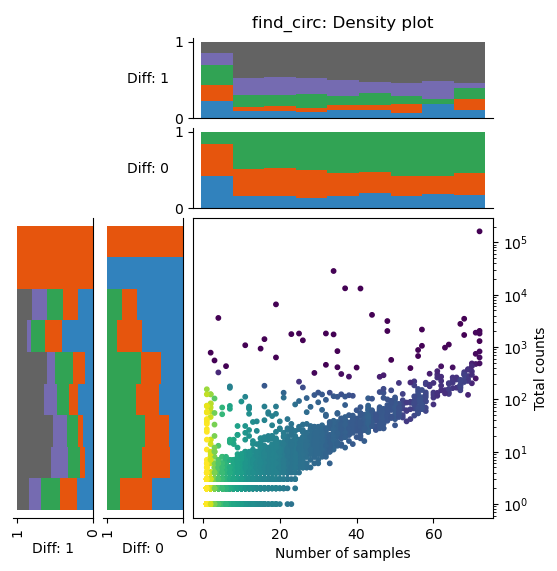

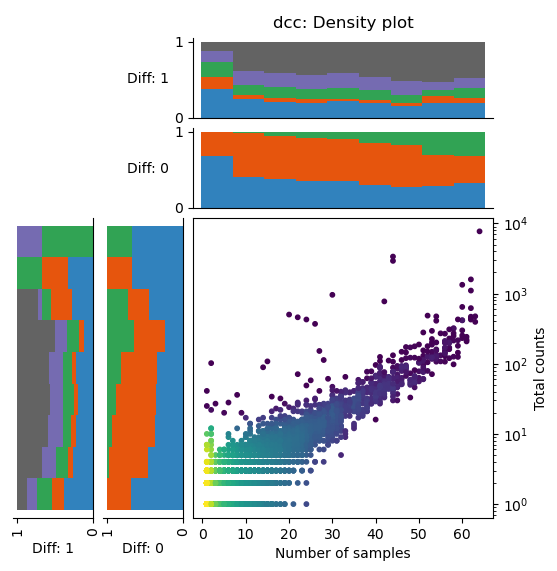

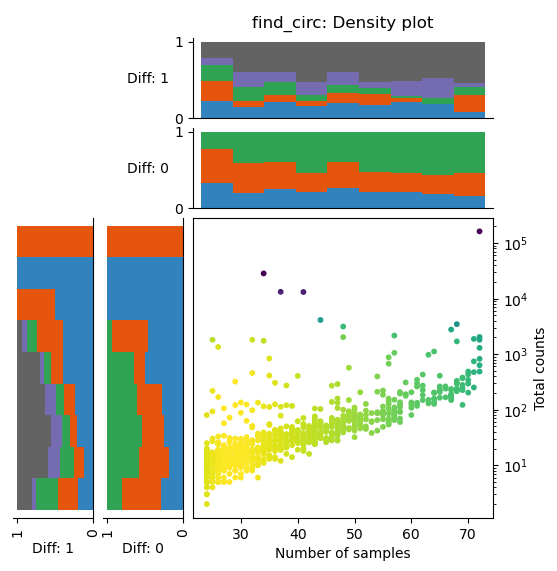

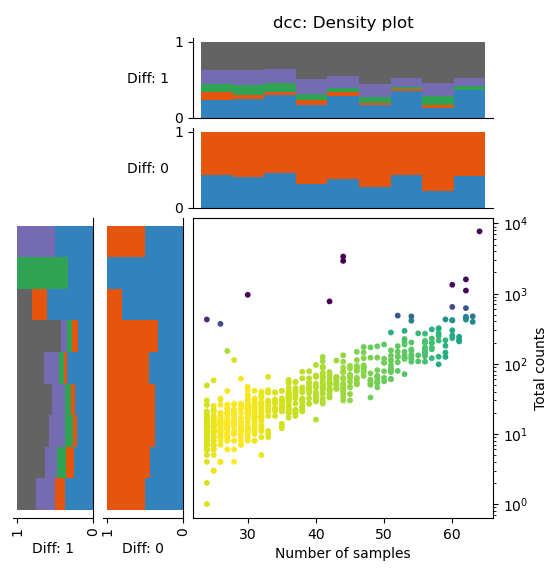

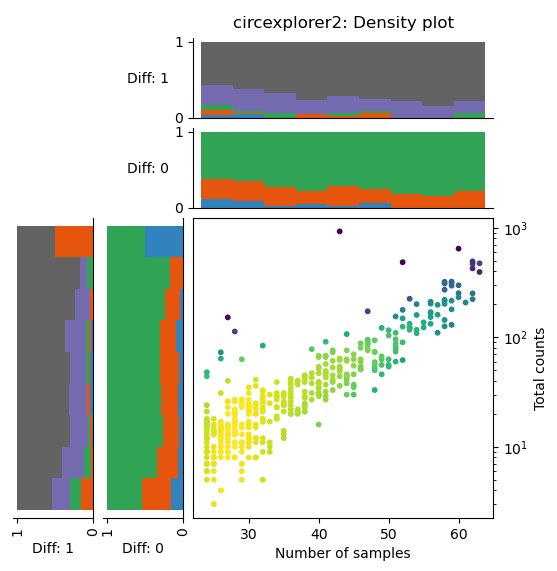

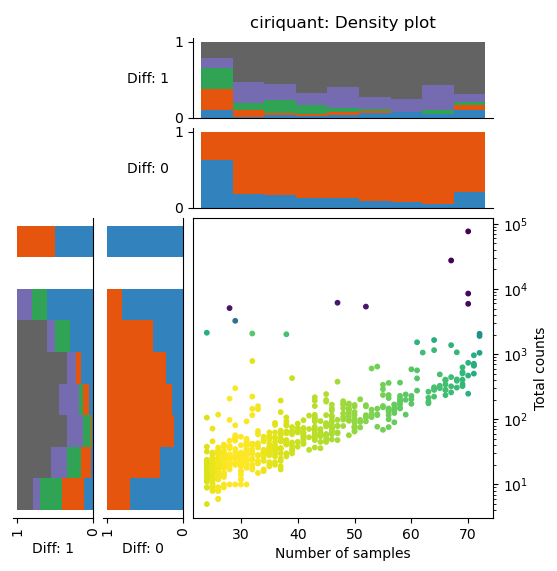

In [14]:
for min_samples in [0, 23]:
    outdir = os.path.join(OUT_DIR, f"min_samples_{min_samples}")
    os.makedirs(outdir, exist_ok=True)
    plot(outdir, min_samples)